In [1]:
#!/usr/bin/env python
# coding: utf-8

import pickle
#import glob
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy import Column, Integer, Text, table
from sqlalchemy.dialects.postgresql import JSON, JSONB
import matplotlib.image as img
import sqlalchemy as sa
import pyodbc
import pandas as pd
import numpy as np
import datetime
import mplfinance as mpf
import matplotlib
import stockstats as ss
from datetime import timedelta, datetime
import yfinance as yf
from io import BytesIO
import trendln
import os

#st.write("Hello")

In [4]:


symbols = pd.read_csv('s:\\screener\\current\\p_weights_long.csv')

#st.write(symbols)

conn_str = (
"DRIVER={PostgreSQL Unicode};"
"DATABASE=testdb;"
"UID=postgres;"
"PWD=Raistlin;"
"SERVER=192.168.3.212;"
"PORT=5432;"
)
connection_uri = sa.engine.URL.create(
    "postgresql",
    username="postgres",
    password='Raistlin',
    host="192.168.3.212",
    database="testdb"
)

engine = create_engine(connection_uri)
conn = pyodbc.connect(conn_str)

#st.write("Before 1st query")
symbol_query =f"""
SELECT symbol 
FROM screener_stg
WHERE ecdf >= (SELECT MAX(sq.ecdf)
FROM
(
SELECT ecdf, COUNT(ecdf) AS Occurrences
FROM screener_stg
GROUP BY ecdf
ORDER BY ecdf DESC
) AS sq
WHERE sq.occurrences >= 20)
"""
symbols = pd.read_sql(symbol_query, con=engine)
#symbols = pd.read_csv('s:\\screener\\current\\p_weights_long.csv')
engine.dispose()


def symbol_str(symbols):
    symbol_str = ''
    for symbol in symbols:
        symbol_str += "'" + symbol + "',"
    return symbol_str[:-1]

engine = create_engine(connection_uri)
conn = pyodbc.connect(conn_str)

#st.write("Before 2nd query")
screener_vol = pd.read_sql(f"""
SELECT date, vol_pct_20d, symbol
FROM public.volatility_price_log pvl
WHERE pvl.symbol IN ({symbol_str(symbols['symbol'])})
AND EXTRACT(YEAR FROM pvl."date") >= (EXTRACT(YEAR FROM CURRENT_DATE) - 3)
""", con = engine)
engine.dispose()

#@st.cache 
def load_screener_data(): 
  engine = create_engine(connection_uri)
  conn = pyodbc.connect(conn_str)
  
  df = pd.read_sql(f"""
  SELECT pv."symbol", "date","open",high,low,"close",adjclose,volume
  FROM prices_vw pv
  WHERE pv.symbol IN ({symbol_str(symbols['symbol'])})
  AND EXTRACT(YEAR FROM pv."date") >= (EXTRACT(YEAR FROM CURRENT_DATE) - 3)
  """, con = engine)
  engine.dispose()
  
  #date_list = [dt.date().strftime('%Y-%m-%d') for dt in pd.to_datetime(screener_returns['date'])]
  #df['ds'] = date_list
  return df 

# Global variable for the dataframe 
#st.write("Before 3rd query")
screener_returns = load_screener_data() 

engine = create_engine(connection_uri)
conn = pyodbc.connect(conn_str)

#st.write("Before 4th query")
quarterly_return_profile_long = pd.read_sql(f"""
select * from avg_qtr_quarterly_returns_trailing_5_years_mvw
where symbol in(
SELECT symbol 
FROM screener_stg
WHERE ecdf >= (SELECT MAX(sq.ecdf)
FROM
(
SELECT ecdf, COUNT(ecdf) AS Occurrences
FROM screener_stg
GROUP BY ecdf
ORDER BY ecdf DESC
) AS sq
WHERE sq.occurrences >= 20)
)
""", con = engine)
engine.dispose()

#st.write("Pivot parsing results")
returns_pvt_long = pd.pivot_table(quarterly_return_profile_long, values=['roll_qtr_return'], index=quarterly_return_profile_long['quarter'],columns=['symbol']).dropna(axis=1,thresh=20)

returns_pvt_long.columns = returns_pvt_long.columns.droplevel(0)


In [ ]:

def on_balance_volume(close_prices, volume):
    obv = [0]
    for i in range(1, len(close_prices)):
        if close_prices[i] > close_prices[i-1]:
            obv.append(obv[i-1] + volume[i])
        elif close_prices[i] < close_prices[i-1]:
            obv.append(obv[i-1] - volume[i])
        else:
            obv.append(obv[i-1])
    return obv

def get_plots(symbol):
    inside_figs = []
    
    formatted_strings = []
    
    data = screener_returns[screener_returns['symbol']==symbol].set_index('date')[['open','high','low','close','adjclose','volume']]
    data['Date'] = data.index
    data.set_index('Date',inplace=True)
    data.sort_index(ascending=False,inplace=True)
    data.index = [pd.to_datetime(pd.to_datetime(d).replace(tzinfo=None).strftime('%Y-%m-%d %H:%M:%S')).date() for d in data.index]

    #only 1 year
    vol_log = screener_vol[screener_vol['symbol']==symbol]
    vol_log.set_index('date',inplace=True)
    #vol_log.index = pd.to_datetime(vol_log.index, format='%Y-%m-%d %H:%M:%S+0000', utc=True)
    vol_log.index = [pd.to_datetime(d).date() for d in vol_log.index]

    # Create stockstats object 
    stock = ss.StockDataFrame.retype(data.tail(512))

    # Calculate Donchian Channels
    donchian_52w = pd.DataFrame({'high': data.sort_index().tail(512)['high'].rolling(window=52
                                ).max(), 'low': data.sort_index().tail(512)['low'].rolling(window=52).min()})
    donchian_180d = pd.DataFrame({'high': data.sort_index().tail(512)['high'].rolling(window=180
                                ).max(), 'low': data.sort_index().tail(512)['low'].rolling(window=180).min()})
    donchian_90d = pd.DataFrame({'high': data.sort_index().tail(512)['high'].rolling(window=90
                                ).max(), 'low': data.sort_index().tail(512)['low'].rolling(window=90).min()})
    donchian_20d = pd.DataFrame({'high': data.sort_index().tail(512)['high'].rolling(window=20
                                ).max(), 'low': data.sort_index().tail(512)['low'].rolling(window=20).min()})

    data.sort_index(ascending=True,inplace=True)
    vol_log.sort_index(ascending=True,inplace=True)
    #vol_log.index = pd.to_datetime(vol_log['vol_pct_20d'].reset_index()['date'])

    data.index = pd.to_datetime(data.index)
    vol_log.index = pd.to_datetime(vol_log.index)

    donchian_52w.sort_index(ascending=True,inplace=True)
    donchian_180d.sort_index(ascending=True,inplace=True)
    donchian_90d.sort_index(ascending=True,inplace=True)
    donchian_20d.sort_index(ascending=True,inplace=True)

    stock = ss.StockDataFrame.retype(data.tail(512))
    data['ema_21'] = data['close'].ewm(span=21).mean()
    data['ema_63'] = data['close'].ewm(span=63).mean()
    data['ema_126'] = data['close'].ewm(span=126).mean()
    data['ema_252'] = data['close'].ewm(span=252).mean()

    obv = pd.DataFrame(on_balance_volume(data['close'],data['volume']),index=data.index,columns=['obv'])

    # Calculate RSI 
    rsi = stock['rsi_14']

    # Calculate MACD 
    #macd = stock['macd']
    macd_hist = stock['macdh']
    signal_line = stock['macds']

    # Calculate MFI 
    mfi = stock['mfi']
    
    stochRSI = stock['stochrsi']
    
    matplotlib.use('Agg')
    fig0 = mpf.figure(figsize=(18, 15))
    ax6 = fig0.add_subplot(7,1,6)
    ax0 = fig0.add_subplot(7,1,1, sharex=ax6)
    ax1 = fig0.add_subplot(7,1,2, sharex=ax6)
    ax1=ax0.twinx()
    ax2 = fig0.add_subplot(7,1,2, sharex=ax6)
    ax3 = fig0.add_subplot(7,1,3, sharex=ax6)
    ax4 = fig0.add_subplot(7,1,4, sharex=ax6)
    ax5 = fig0.add_subplot(7,1,5, sharex=ax6)
    ax7 = ax2.twinx()
    #ax7 = fig0.add_subplot(8,1,7, sharex=ax6)
    ax8 = fig0.add_subplot(7,1,7, sharex=ax6)
    

    ap0 = [
        mpf.make_addplot(mfi.tail(126), color='#FFa500', panel=1, title='MFI(Orange)/Stochastic RSI(Red)', ax=ax0),
        #mpf.make_addplot(rsi.tail(126), color='#00FF00', panel=1, ax=ax1),
        mpf.make_addplot(stochRSI.tail(126), color='#ff0000', panel=1, ax=ax1),
        mpf.make_addplot(macd_hist.tail(126), color='#ff0059', panel=1, title='MACDH (Red), MACDS (Green), On Balance Volume (Cyan)', ax=ax2),
        mpf.make_addplot(signal_line.tail(126), color='#00FF00', panel=1, ax=ax2),
        mpf.make_addplot(obv['obv'].tail(126), color='#00d9ff', panel=1, ax=ax7),
        mpf.make_addplot(donchian_52w.tail(126), color='#005aff', panel=1, ax=ax3),
        mpf.make_addplot(donchian_180d.tail(126), color='#ff0059', panel=1, ax=ax3),
        mpf.make_addplot(donchian_90d.tail(126), color='#00ff25', panel=1, ax=ax3),
        mpf.make_addplot(donchian_20d.tail(126), color='#00d9ff', panel=1, ax=ax3),
        mpf.make_addplot(data['close'].tail(126), color='#4b0082', panel=1, title='Close/Donchian', ax=ax3),
        mpf.make_addplot(vol_log.reindex(data.tail(126).index)['vol_pct_20d'], color='#ee82ee', panel=1, title='Volatility', ax=ax4),
        mpf.make_addplot(data['ema_21'].tail(126), color='#00ff25', panel=1, ax=ax5),
        mpf.make_addplot(data['ema_63'].tail(126), color='#005aff', panel=1, ax=ax5),
        mpf.make_addplot(data['ema_126'].tail(126), color='#ff0059', panel=1, title='1Mo EMA (Green),1Q EMA (Blue),6mo EMA (Red)', ax=ax5),
        mpf.make_addplot(stock['pdi'].tail(126), color='#00FF00', panel=1, title='DMI: PDI (Green), MDI (red), DX (Orange), ADX (Blue), ADXR (Cyan)', ax=ax8),
        mpf.make_addplot(stock['mdi'].tail(126), color='#ff0000', panel=1, ax=ax8),
        mpf.make_addplot(stock['dx'].tail(126), color='#FFa500', panel=1, ax=ax8),
        mpf.make_addplot(stock['adx'].tail(126), color='#005aff', panel=1, ax=ax8),
        mpf.make_addplot(stock['adxr'].tail(126), color='#00ffff', panel=1, ax=ax8)
    ]

        #figure out fibonacci retracement lines for support and resistance
        #,hlines=dict(hlines=[support,resistance],colors=['g','r'],linestyle='-.')
        #indicators=['doji', 'piercing', 'engulfing','shooting star']
        #figscale=1,fill_between=dict(y1=data['low'].values,y2=data['high'].values)
    mpf.plot(data.tail(126),ax=ax5, addplot=ap0, volume=ax6, type='hollow_and_filled',style='blueskies', show_nontrading=True)

    fig0.subplots_adjust(hspace=.3)
    ax0.tick_params(labelbottom=False,size=6)
    ax1.tick_params(labelbottom=False,size=6)
    ax2.tick_params(labelbottom=False,size=6)
    ax3.tick_params(labelbottom=False,size=6)
    ax4.tick_params(labelbottom=False,size=6)
    ax5.tick_params(labelbottom=False,size=6)
    ax6.tick_params(labelbottom=False,size=6)
    ax7.tick_params(labelbottom=False,size=6)
    ax8.tick_params(labelbottom=True,size=6)
    #ax3.yaxis.set_label_position('left')
    #ax3.yaxis.tick_left()
    plt.legend()
    
    #inside_figs.append(fig0)
    
    buf0 = BytesIO()
    fig0.savefig(buf0, format="png")
    img0 = Image.open(buf0)
    
    #st.markdown('Streamlit is **_really_ cool**.')
    #st.markdown("This text is :red[colored red], and this is **:blue[colored]** and bold.")
    #st.markdown(":green[$\sqrt{x^2+y^2}=1$] is a Pythagorean identity. :pencil:")
    
    if(macd_hist[-1] < signal_line[-1]):
        formatted_strings.append("MACDS > MACDH : **:green[Buy]**")
        #st.markdown("MACDS > MACDH : **:green[Buy]**")
    if(macd_hist[-1] > signal_line[-1]):
        formatted_strings.append("MACDS < MACDH : **:red[Sell]**")
        #st.markdown("MACDS < MACDH : **:red[Sell]**")
    if(mfi[-1] <= .2):
        formatted_strings.append("MFI < .2: **:green[Buy]**")
        #st.markdown("MFI < .2: **:green[Buy]**")
    if(mfi[-1] >= .8):
        formatted_strings.append("MFI > .8: **:red[Sell]**")
        #st.markdown("MFI > .8: **:red[Sell]**")
    if(vol_log['vol_pct_20d'].values[-1] < .25):
        formatted_strings.append("Volatility < .25 : **:green[Buy]**")
        #st.markdown("Volatility < .25 : **:green[Buy]**")        
    if(vol_log['vol_pct_20d'].values[-1] > .5):
        formatted_strings.append("Volatility > .5: **:red[Sell]**")
        #st.markdown("Volatility > .5: **:red[Sell]**")
    if(rsi[-1] < 30):
        formatted_strings.append("RSI < 30 Oversold : **:green[Buy]**")        
        #st.markdown("RSI < 30 Oversold : **:green[Buy]**")        
    if(rsi[-1] > 70):
        formatted_strings.append("RSI > 70 Overbought : **:red[Sell]**")        
        #st.markdown("RSI > 70 Overbought : **:red[Sell]**")        
    if((rsi[-1] > 50) and (rsi[-2]<50)):
        formatted_strings.append("RSI + crossover : **:green[Buy]**")
        #st.markdown("RSI + crossover : **:green[Buy]**")
    if((rsi[-1] < 50) and (rsi[-2]>50)):
        formatted_strings.append("RSI - crossover : **:red[Sell]**")
        #st.markdown("RSI - crossover : **:red[Sell]**")

    # Strong Upward Trend
    if (stock['pdi'][-1] > stock['mdi'][-1]) and (stock['dx'][-1] > stock['adx'][-1]):
        formatted_strings.append("Strong Upward Trend detected : **:green[Buy]**")
        #st.markdown("Strong Upward Trend detected : **:green[Buy]**")
    
    # Strong Downward Trend
    if (stock['pdi'][-1] < stock['mdi'][-1]) and (stock['dx'][-1] > stock['adx'][-1]):
        formatted_strings.append("Strong Downward Trend detected : **:red[Sell]**")
        #st.markdown("Strong Downward Trend detected : **:red[Sell]**")
    
    # Weak Upward Trend
    if (stock['pdi'][-1] > stock['mdi'][-1]) and (stock['dx'][-1] < stock['adx'][-1]):
        formatted_strings.append("Weak Upward Trend detected: :[Buy]")
        #st.markdown("Weak Upward Trend detected: :[Buy]")
    
    # Weak Downward Trend
    if (stock['pdi'][-1] < stock['mdi'][-1]) and (stock['dx'][-1] < stock['adx'][-1]):
        formatted_strings.append("Weak Downward Trend detected: :[Sell]")
        #st.markdown("Weak Downward Trend detected: :[Sell]")
    
    # Trend Reversal
    if (stock['adxr'][-1] < stock['adxr'][-2]):
        if (stock['pdi'][-1] > stock['mdi'][-1]):
        # Positive trend
            # Reversal detected
            formatted_strings.append("Positive trend reversal detected :[Buy]")
            #st.markdown("Positive trend reversal detected :[Buy]")
        elif (stock['mdi'][-1] > stock['pdi'][-1]):
        # Negative trend
            # Reversal detected
            formatted_strings.append("Negative trend reversal detected :[Sell]")
            #st.markdown("Negative trend reversal detected :[Sell]")
        
    # Buy Signal
    if (macd_hist[-1] > signal_line[-1]) and (macd_hist[-2] < signal_line[-2]):
        formatted_strings.append("Buy Signal detected : **:green[Buy]**")
        #st.markdown("Buy Signal detected : **:green[Buy]**")
    
    # Sell Signal
    if (macd_hist[-1] < signal_line[-1]) and (macd_hist[-2] > signal_line[-2]):
        formatted_strings.append("Sell Signal detected : **:red[Sell]**")
        #st.markdown("Sell Signal detected : **:red[Sell]**")
        
    # Buy Signal
    if (data['ema_21'][-1] > data['ema_126'][-1]):
        formatted_strings.append("Golden Cross : **:green[Buy]**")
        #st.markdown("Golden Cross : **:green[Buy]**")
    
    # Sell Signal
    if (data['ema_21'][-1] < data['ema_126'][-1]):
        formatted_strings.append("Death Cross : **:red[Sell]**")  
        #st.markdown("Death Cross : **:red[Sell]**")
        
    
    #st.image(img,use_column_width='never',width=1800)
    # Calculate support and resistance lines

    h = data['close']
    mins, maxs = trendln.calc_support_resistance(h)
    (minimaIdxs, pmin, mintrend, minwindows), (maximaIdxs, pmax, maxtrend, maxwindows) = mins, maxs
    
    # Plot support and resistance lines
    
    idx = data.index
    #fig = trendln.plot_sup_res_date((data['low'], data['high']), idx)
    fig1 = trendln.plot_sup_res_date((data['low'].tail(126), data['high'].tail(126)), idx[-126:])
    #inside_figs.append(fig1)
    buf1 = BytesIO()    
    fig1.savefig(buf1, format="png")
    img1 = Image.open(buf1)
        
    # Convert BytesIO object to PIL image
    
    # Display image with st.image
    
    return([symbol,[formatted_strings, [img0,img1]]])
    #st.image(buf, use_column_width='never',width=1800)


In [6]:
plot = get_plots('WNC')

C:\Users\User\AppData\Local\Temp\ipykernel_16680\4009652128.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vol_log.sort_index(ascending=True,inplace=True)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


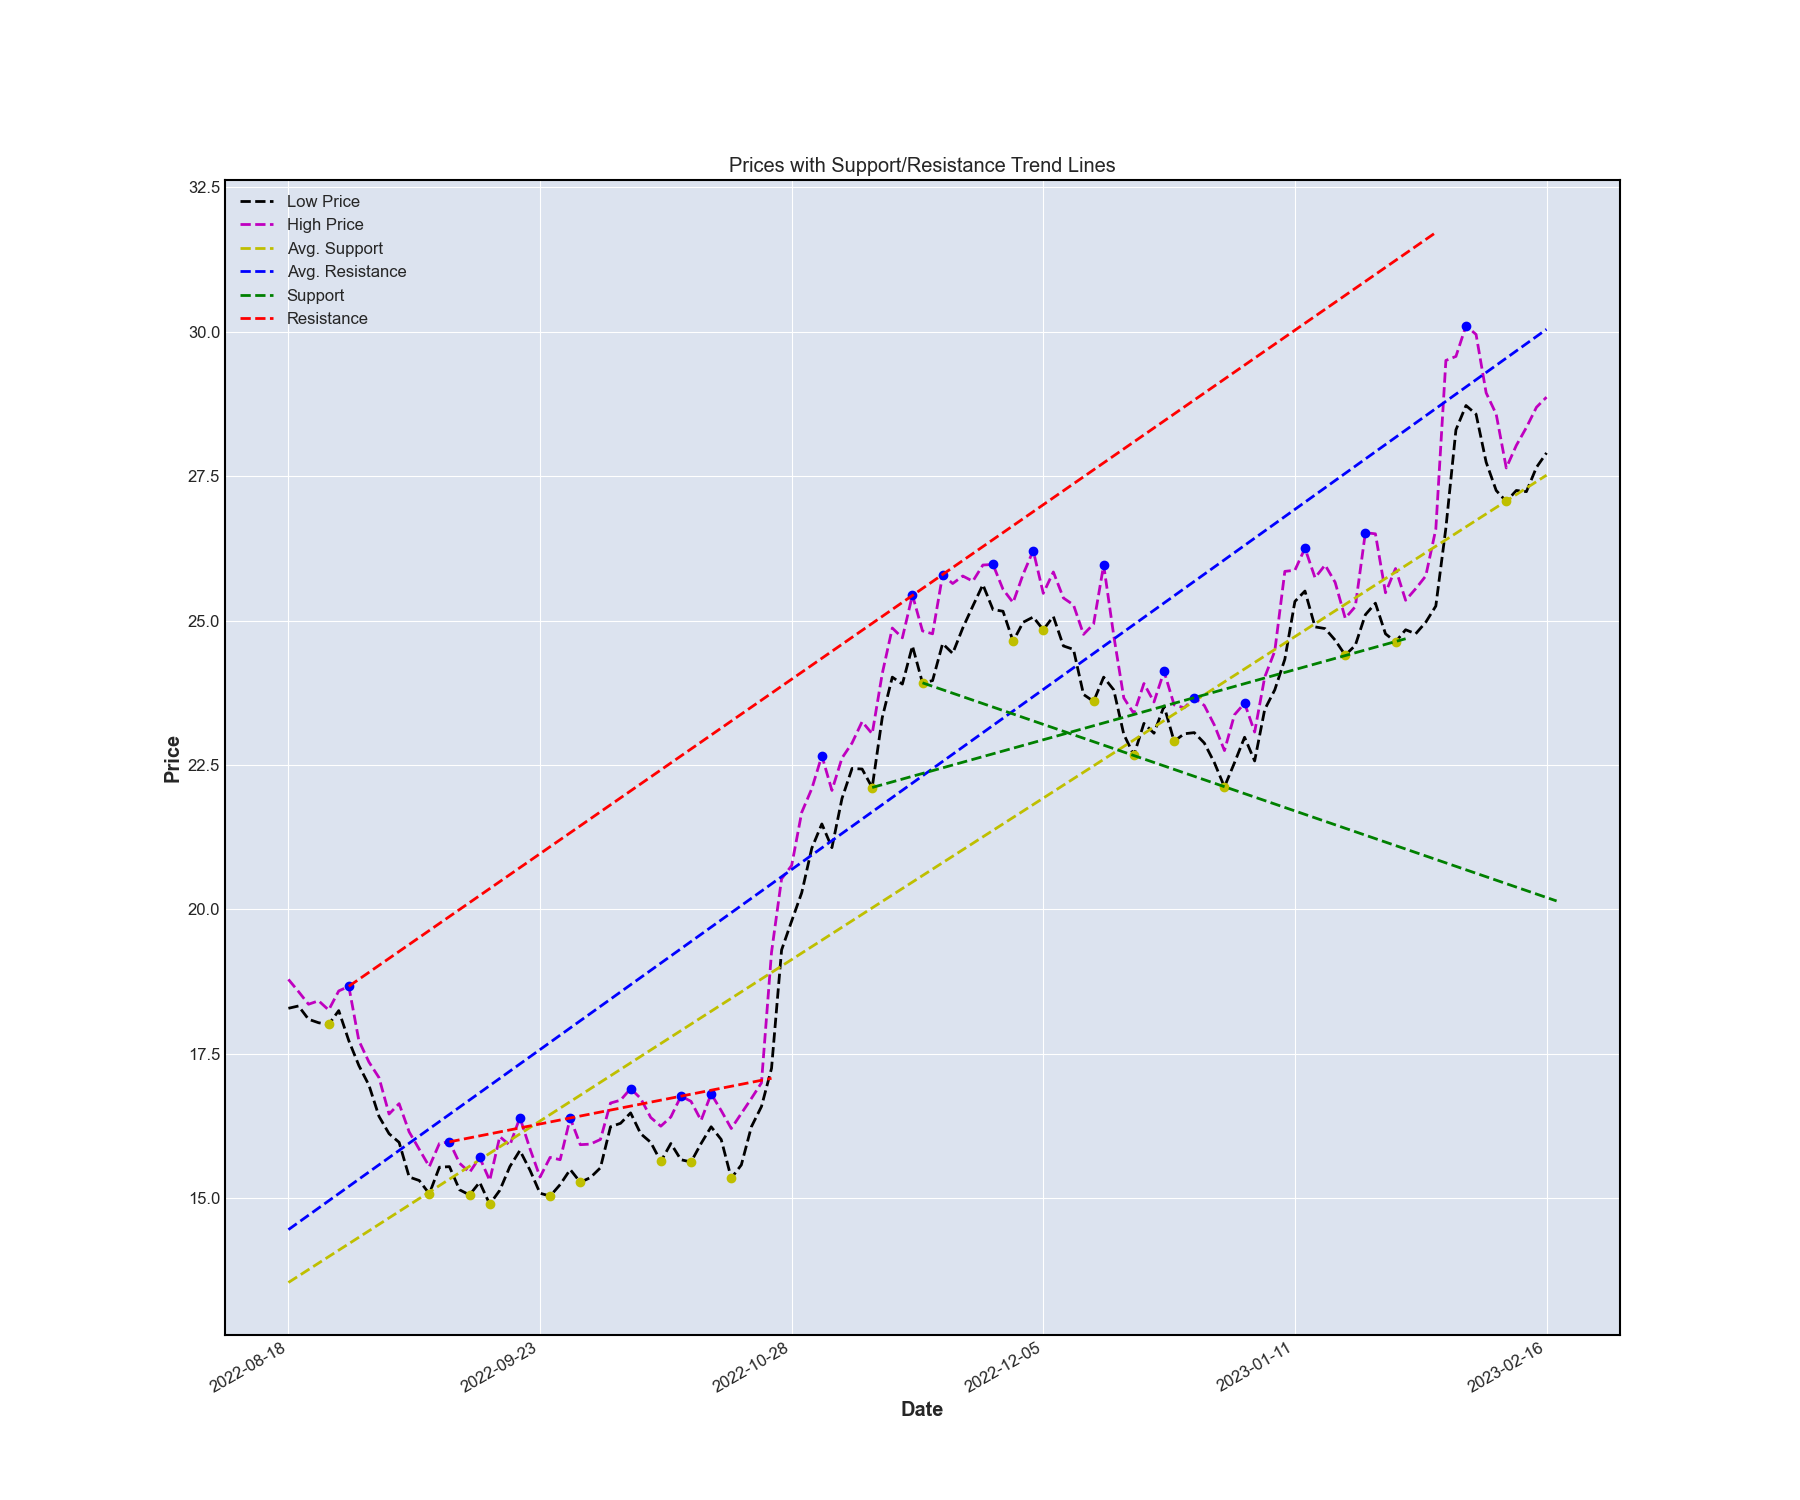

In [11]:
plot[1][1][1]